In [1]:
import torch
import torch as th
import torch.nn as nn
from torch import Tensor

import copy
import random
import numpy as np
import matplotlib as mpl
import compress_pickle as cpkl

import rsatoolbox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # TODO: move to the top

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from ss_baselines.common.utils import plot_top_down_map

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white" 

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/audiogoal_rgb_nocont.yaml"),

    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "deep-etho",
                    "perceiver-gwt-gwwm", "perceiver-gwt-attgru"]),
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

In [3]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
# envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
# Dummy environment spaces
from gym import spaces
single_action_space = spaces.Discrete(4)
single_observation_space = spaces.Dict({
    "rgb": spaces.Box(shape=[128,128,3], low=0, high=255, dtype=np.uint8),
    "depth": spaces.Box(shape=[128,128,1], low=0, high=255, dtype=np.uint8),
    "audiogoal": spaces.Box(shape=[2,16000], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32),
    "spectrogram": spaces.Box(shape=[65,26,2], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32)
})
# single_observation_space = envs.observation_spaces[0]
# single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), depth:Box(0, 255, (128, 128, 1), uint8), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 Discrete(4))

# Loading the Category-Scene-Trajs file

In [4]:
# Specify file name
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

# Read the filtred trajectories data
## Default format is {cat -> { scenes -> traj: []}}
with open(analysis_trajs_filename, "rb") as f:
    cats_scenes_trajs_dict = cpkl.load(f)

In [5]:
# Extract some global metadata
TARGET_SCENE_LIST = list(cats_scenes_trajs_dict[list(cats_scenes_trajs_dict.keys())[0]].keys())
TARGET_SCENE_DICT = {scene: i for i, scene in enumerate(TARGET_SCENE_LIST)}
TARGET_CATEGORY_LIST = list(cats_scenes_trajs_dict.keys())
TARGET_CATEGORY_DICT = {cat: i for i, cat in enumerate(TARGET_CATEGORY_LIST)}

C = len(TARGET_CATEGORY_LIST) # C: total number of categories
M = len(TARGET_SCENE_LIST) # M: total number of rooms, assuming all categories has N trajs for a same set of scenes.

print(f"# of categories C: {C} | # of scenes: {M}")
print(f"TARGET_CATEGORY_DICT: {TARGET_CATEGORY_DICT}")
print(f"TARGET_SCENE_DICT: {TARGET_SCENE_DICT}")
print("")

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"Cat: {catname}; Scenes: {[k for k in cat_scenes_trajs.keys()]}")

# of categories C: 6 | # of scenes: 5
TARGET_CATEGORY_DICT: {'chair': 0, 'picture': 1, 'table': 2, 'cushion': 3, 'cabinet': 4, 'plant': 5}
TARGET_SCENE_DICT: {'gTV8FGcVJC9': 0, 'b8cTxDM8gDG': 1, 'D7N2EKCX4Sj': 2, 'Vvot9Ly1tCj': 3, 'vyrNrziPKCB': 4}

Cat: chair; Scenes: ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
Cat: picture; Scenes: ['gTV8FGcVJC9', 'D7N2EKCX4Sj', 'vyrNrziPKCB', 'Vvot9Ly1tCj', 'b8cTxDM8gDG']
Cat: table; Scenes: ['vyrNrziPKCB', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'gTV8FGcVJC9']
Cat: cushion; Scenes: ['b8cTxDM8gDG', 'Vvot9Ly1tCj', 'vyrNrziPKCB', 'gTV8FGcVJC9', 'D7N2EKCX4Sj']
Cat: cabinet; Scenes: ['gTV8FGcVJC9', 'vyrNrziPKCB', 'b8cTxDM8gDG', 'Vvot9Ly1tCj', 'D7N2EKCX4Sj']
Cat: plant; Scenes: ['gTV8FGcVJC9', 'Vvot9Ly1tCj', 'b8cTxDM8gDG', 'vyrNrziPKCB', 'D7N2EKCX4Sj']


In [6]:
# More detailed breakdown of the trajectories per categories then scenes
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"\t{scene}: {traj_lengths}")
    print("")

chair:
	gTV8FGcVJC9: [28, 10, 46, 9, 6]
	b8cTxDM8gDG: [15, 19, 26, 20, 8]
	D7N2EKCX4Sj: [19, 36, 12, 40, 33]
	Vvot9Ly1tCj: [18, 21, 23, 16, 27]
	vyrNrziPKCB: [20, 24, 10, 14, 28]

picture:
	gTV8FGcVJC9: [10, 12, 16, 20, 17]
	D7N2EKCX4Sj: [46, 31, 53, 39, 43]
	vyrNrziPKCB: [12, 38, 18, 14, 15]
	Vvot9Ly1tCj: [24, 51, 31, 41, 35]
	b8cTxDM8gDG: [33, 12, 13, 20, 11]

table:
	vyrNrziPKCB: [22, 22, 54, 57, 12]
	b8cTxDM8gDG: [17, 9, 16, 25, 14]
	D7N2EKCX4Sj: [6, 31, 24, 28, 17]
	Vvot9Ly1tCj: [23, 41, 14, 34, 32]
	gTV8FGcVJC9: [16, 13, 15, 18, 15]

cushion:
	b8cTxDM8gDG: [7, 14, 22, 12, 8]
	Vvot9Ly1tCj: [36, 32, 47, 36, 46]
	vyrNrziPKCB: [62, 18, 21, 42, 54]
	gTV8FGcVJC9: [10, 11, 27, 7, 13]
	D7N2EKCX4Sj: [21, 12, 14, 14, 20]

cabinet:
	gTV8FGcVJC9: [13, 13, 18, 47, 13]
	vyrNrziPKCB: [30, 22, 22, 40, 47]
	b8cTxDM8gDG: [10, 14, 21, 24, 16]
	Vvot9Ly1tCj: [9, 35, 42, 39, 28]
	D7N2EKCX4Sj: [21, 34, 14, 40, 10]

plant:
	gTV8FGcVJC9: [6, 13, 42, 6, 41]
	Vvot9Ly1tCj: [16, 47, 23, 11, 26]
	b8cTxDM8gDG:

In [7]:
## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

In [8]:
# Basic check of the scene -> categories fileted trajectors
# for scene, scenes_cat_trajs in scenes_cats_trajs_dict.items():
#     print(f"Scene: {scene}; Cats: {[k for k in scenes_cat_trajs.keys()]}")

# More detailed breakdown of the trajectories per categories then scenes
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

gTV8FGcVJC9
	chair: [28, 10, 46, 9, 6]
	picture: [10, 12, 16, 20, 17]
	table: [16, 13, 15, 18, 15]
	cushion: [10, 11, 27, 7, 13]
	cabinet: [13, 13, 18, 47, 13]
	plant: [6, 13, 42, 6, 41]

b8cTxDM8gDG
	chair: [15, 19, 26, 20, 8]
	picture: [33, 12, 13, 20, 11]
	table: [17, 9, 16, 25, 14]
	cushion: [7, 14, 22, 12, 8]
	cabinet: [10, 14, 21, 24, 16]
	plant: [6, 8, 13, 11, 8]

D7N2EKCX4Sj
	chair: [19, 36, 12, 40, 33]
	picture: [46, 31, 53, 39, 43]
	table: [6, 31, 24, 28, 17]
	cushion: [21, 12, 14, 14, 20]
	cabinet: [21, 34, 14, 40, 10]
	plant: [27, 31, 37, 26, 47]

Vvot9Ly1tCj
	chair: [18, 21, 23, 16, 27]
	picture: [24, 51, 31, 41, 35]
	table: [23, 41, 14, 34, 32]
	cushion: [36, 32, 47, 36, 46]
	cabinet: [9, 35, 42, 39, 28]
	plant: [16, 47, 23, 11, 26]

vyrNrziPKCB
	chair: [20, 24, 10, 14, 28]
	picture: [12, 38, 18, 14, 15]
	table: [22, 22, 54, 57, 12]
	cushion: [62, 18, 21, 42, 54]
	cabinet: [30, 22, 22, 40, 47]
	plant: [36, 21, 59, 34, 34]



## Helpers to extract traj. data based on "category", "scene", etc...

In [9]:
cats_scenes_trajs_dict["chair"]["D7N2EKCX4Sj"][0]["edd"]["scene_id"]

'D7N2EKCX4Sj'

In [10]:
# region: Categories -> Scenes
## cats_scenes_trajs_dict: dictionary structured as: {category: {scene: [traj_data]}}
def get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, trajIdx=0, tensorize=False):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[category][scene][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[category][scene][trajIdx]["edd"]["done_list"]

    obs_dict_list = []
    target_scene_idx_list, target_category_idx_list = [], []

    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(TARGET_CATEGORY_DICT[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done]))) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :]
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=0, tensorize=False):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    N_SCENES = len(trajs_dicts[category][scene])
    res_n_scenes = N_SCENES if max_scenes <= 0 else max_scenes

    for i in range(N_SCENES):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, i, tensorize=tensorize)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")
        if i >= res_n_scenes - 1:
            break

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category(trajs_dicts, category, max_scenes=0, tensorize=False):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts[category].keys():
        scene_obs_dict_list, scene_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=max_scenes, tensorize=tensorize)

        obs_dict_list.extend(scene_obs_dict_list)
        done_list.extend(scene_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Categories -> Scenes

# region: Scenes -> Categories
# TODO: add "return" for target categories and scenes label
## scenes_cats_trajs_dict: dictionary structured as: {scene: {category: [traj-data]}}
def get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, trajIdx=0, tensorize=False):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[scene][category][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[scene][category][trajIdx]["edd"]["done_list"]
    target_scene_idx_list, target_category_idx_list = [], []

    obs_dict_list = []
    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(TARGET_CATEGORY_DICT[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done]))) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :]
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list
        
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene_category(trajs_dicts, scene, category, tensorize=False):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    for i in range(len(trajs_dicts[scene][category])):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, i, tensorize=tensorize)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene(trajs_dicts, scene, tensorize=False):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []
    
    for cat in trajs_dicts[scene].keys():
        cat_obs_dict_list, cat_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category(trajs_dicts, scene, cat, tensorize=tensorize)

        obs_dict_list.extend(cat_obs_dict_list)
        done_list.extend(cat_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Scenes -> Categories

## Actually extract some trajectories.

### Categories first

In [12]:
# Specific trajectory by category -> scene -> index
# obs_dict_list, done_list = \
#     get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, "chair", "D7N2EKCX4Sj", 2, tensorize=True)

# Specific trajectories by category, then scene
# obs_dict_list, done_list = \
#     get_traj_data_by_category_scene(cats_scenes_trajs_dict, "chair", "D7N2EKCX4Sj", tensorize=True)

# Specific trajectories by category, then scene, with only one traj per scene
# obs_dict_list, done_list = \
#     get_traj_data_by_category(cats_scenes_trajs_dict, "chair", max_scenes=1, tensorize=True)

# Specific trajectorieds by category
# obs_dict_list, done_list = \
#     get_traj_data_by_category(cats_scenes_trajs_dict, "chair", tensorize=True)


# region: chair, all scenes, all trajectories
# Specified category: all scenes and all trajs
chair_allscenes_all_traj__obs_dict_list, \
chair_allscenes_all_traj__done_list, \
chair_allscenes_all_traj__target_scene_idx_list, \
chair_allscenes_all_traj__target_category_idx_list = \
    get_traj_data_by_category(cats_scenes_trajs_dict, "chair", tensorize=True)

# Override {obs_dict, done}_list for downstream processing
obs_dict_list, done_list = \
        chair_allscenes_all_traj__obs_dict_list, \
        chair_allscenes_all_traj__done_list

# Quick check:
len(chair_allscenes_all_traj__obs_dict_list), len(chair_allscenes_all_traj__obs_dict_list), len(chair_allscenes_all_traj__obs_dict_list)
# endregion: chair, all scenes, all trajectories


# print(f"done_list shape: {np.shape(done_list)}")
# print(len(obs_dict_list))

# print(np.array(done_list).astype(np.uint8))
# for k, v in obs_dict_list.items():
#     print(f"{k}: {np.shape(v)}")

(528, 528, 528)

### Scenes first

In [ ]:
# Specify trajectory by scene -> category -> index
# obs_dict_list, done_list = \
#     get_traj_data_by_scene_category_trajIdx(scenes_cats_trajs_dict, "D7N2EKCX4Sj", "chair", 0, tensorize=True)

# Specify trajectories by scene, then category
# obs_dict_list, done_list = \
#     get_traj_data_by_scene_category(scenes_cats_trajs_dict, "D7N2EKCX4Sj", "chair", tensorize=True)

# All trajectories by scene, for all categories
# obs_dict_list, done_list = \
#     get_traj_data_by_scene(scenes_cats_trajs_dict, "D7N2EKCX4Sj", tensorize=True)

# region: D7N2EKCX4Sj, all categories, all trajectories
# D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list, \
# D7N2EKCX4Sj_allcats_alltrajs_done_list, \
# D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list, \
# D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list = \
#         get_traj_data_by_scene(scenes_cats_trajs_dict, "D7N2EKCX4Sj", tensorize=True)

# # Special sections will override "obs_dict_list" and "done_list"
# obs_dict_list, done_list = \
#         D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list, \
#         D7N2EKCX4Sj_allcats_alltrajs_done_list
# endregion: D7N2EKCX4Sj, all categories, all trajectories

# The following three should all be equal: one target for scene / category for each step
# len(D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list)

# print(f"done_list shape: {np.shape(done_list)}")
# print(len(obs_dict_list))

# print(np.array(done_list).astype(np.uint8))
# for k, v in obs_dict_list.items():
#     print(f"{k}: {np.shape(v)}")

In [13]:
# done_list
for k, v in obs_dict_list[0].items():
    print(f"{k}: {v.shape}, {v.dtype}")

depth: torch.Size([1, 128, 128, 1]), torch.float32
rgb: torch.Size([1, 128, 128, 3]), torch.float32
audiogoal: torch.Size([1, 2, 16000]), torch.float32
spectrogram: torch.Size([1, 65, 26, 2]), torch.float32
category: torch.Size([1, 21]), torch.float32
pointgoal_with_gps_compass: torch.Size([1, 2]), torch.float32
pose: torch.Size([1, 4]), torch.float32


In [14]:
obs_dict_list[0]["rgb"].dtype, len(obs_dict_list)

(torch.float32, 528)

# RSA over agent's features

In [15]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
from models import ActorCritic, Perceiver_GWT_GWWM_ActorCritic

MODEL_VARIANTS_TO_STATEDICT_PATH = {

    # Random GRU Baseline
    "ppo_gru__random": {
        "pretty_name": "GRU Random",
        "state_dict_path": ""
    },
    # Random PGWT Baseline
    "ppo_pgwt__random": {
        "pretty_name": "TransRNN Random",
        "state_dict_path": ""
    },

    
    # SAVi BC Baseline variants
    "ppo_gru__bc__SAVi": {
        "pretty_name": "[SAVi] PPO GRU (BC)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1__rgb_depth_spectro__gru_seed_111__2023_05_23_23_17_03_387659.musashi"
            "/models/ppo_agent.4995001.ckpt.pth"
    },
    "ppo_pgwt__bc__SAVi": {
        "pretty_name": "[SAVi] PPO PGWT (BC)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1__rgb_depth_spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2023_05_23_23_17_04_044443.musashi"
            "/models/ppo_agent.4995001.ckpt.pth"
    },
}

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    # Override args depending on the model in use
    if k.__contains__("gru"):
        agent = ActorCritic(single_observation_space, single_action_space, args.hidden_size, extra_rgb=False,
            analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("pgwt"):
        agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
            analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"])
        agent.load_state_dict(agent_state_dict)
    
    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

In [16]:
# For the collected observation samples, record the intermediate features
# for each agent varaint investigated
dev = th.device("cpu") # NOTE / TODO: using GPU to be more efficient ?


AGENT_FEATURES__RAW = {k: {} for k in MODEL_VARIANTS_TO_AGENTMODEL.keys()}
AGENT_RNN_HIDDEN_STATE = {}
for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
    if agent_variant.__contains__("gru"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
    elif agent_variant.__contains__("pgwt"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = agent_model.state_encoder.latents.clone()

# TODO: Add tqdm support ?
# for t, (obs_th, done_th) in enumerate(zip(obs_th_list, done_th_list)):
for t, (obs_th, done_th) in enumerate(zip(obs_dict_list, done_list)):
    # TODO: if multiple episodes are cated together, need to make sure that the done_th_list reflects that
    # other the hidden latents will not be reset

    # Feeding the same sequence of observatiosn to each type of agent
    masks = 1. - done_th[:, None]
    with th.no_grad():
        for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
            # NOTE: rnn_hidden_state or pgwt's latent are already collected in "state_encoder" field in _features
            _, _, _, _, _, _, AGENT_RNN_HIDDEN_STATE[agent_variant] = \
                agent_model.act(obs_th, AGENT_RNN_HIDDEN_STATE[agent_variant], masks)

            # Collecting intermediate layers results
            for k, v in agent_model._features.items():
                if k not in list(AGENT_FEATURES__RAW[agent_variant].keys()):
                    AGENT_FEATURES__RAW[agent_variant][k] = []
                AGENT_FEATURES__RAW[agent_variant][k].append(v)

# After recording the intermediate layers features, process them to handle the 
# various shape depending on the layers: for example MHA has different stored features
# shape than GRU network, and so on.

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.cat(v, dim=0)
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.cat(vv, dim=0) for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

AGENT_FEATURES = {} # { agent_variant -> agent_feature_dict }
for k, v in AGENT_FEATURES__RAW.items():
    AGENT_FEATURES[k] = process_analysis_feats_raw(v)

In [17]:
from copy import deepcopy
from rsatoolbox.rdm.rdms import RDMs
from rsatoolbox.data import average_dataset_by
from rsatoolbox.util.rdm_utils import _extract_triu_

# from sklearn import preprocessing
from scipy import spatial

In [18]:
def _parse_input(dataset, descriptor):
    if descriptor is None:
        measurements = dataset.measurements
        desc = np.arange(measurements.shape[0])
        descriptor = 'pattern'
    else:
        measurements, desc, _ = average_dataset_by(dataset, descriptor)
    return measurements, desc, descriptor

# TODO: cosine similarity to evaluate similarity ?

def calc_rdm_cosine_dist(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "cosine")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def calc_rdm_correlation_sim(dataset, descriptor=None):
    """
    calculates an RDM from an input dataset using correlation distance
    If multiple instances of the same condition are found in the dataset
    they are averaged.
    The returned value will be the similarities instead of dissimilarities

    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset

    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM

    """
    ma, desc, descriptor = _parse_input(dataset, descriptor)
    ma = ma - ma.mean(axis=1, keepdims=True)
    ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
    rdm = np.einsum('ik,jk', ma, ma)
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='correlation',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# NOTE: all of thoes are dissimilarity metrics, so requires a 
# a receiprocal method to convert to similarity instead.
RSA_DISSIM_METRICS = {
    # "rsa_correlation": {
    #     "fn": rsatoolbox.rdm.calc_rdm_correlation,
    #     "pretty_name": "Pearson Correlation (Dissimilarity is high)",
    #     "vmin": 0, "vmax": 1
    # },
    # TODO: Similarity based on Pearson correlation seems to be bugged
    # One hint is that the computed metric is not good when the deno is 0, or the 
    # frames are very dissimilar.
    "rsa_correlation_sim": {
        "fn": calc_rdm_correlation_sim,
        "pretty_name": "Pearson Correlation (Similiarity is high)",
        "vmin": 0, "vmax": 1
    },
}

In [19]:
# Systematic plotting for each shared intermediate layers
all_layers = []
for v in AGENT_FEATURES.values():
    all_layers.extend(v.keys())
all_layers = set(all_layers); all_layers

# Extract shared layers, and other groups of layers of interest
shared_layers = []
visual_encoder_layernames = []
audio_encoder_layernames = []
for x in all_layers:
    x_found_in_all = True
    for v in AGENT_FEATURES.values():
        if x not in v.keys():
            x_found_in_all = False
            break
    
    if x_found_in_all:
        shared_layers.append(x)
    
    if x.startswith("visual_encoder"):
        visual_encoder_layernames.append(x)
    if x.startswith("audio_encoder"):
        audio_encoder_layernames.append(x)

# Pre-compute all sparsities
# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

VARIANT_LAYERS_SPARSITIES = {k: {} for k in MODEL_VARIANTS_TO_STATEDICT_PATH.keys()}

# NOTE: manually chose the metric for the RDM computation
# DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_euclid
DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_correlation
# DISS_CALC_FN = calc_rdm_cosine_dist # Custom Cosine distance (Similarity
# DISS_CALC_FN = calc_rdm_isc # Custom 'Improved Sqrd Root' 
# DISS_CALC_FN = calc_rdm_isc

# Placeholder for the whole RDMs for each agent varaint
# "variant" -> "layer" -> "metric" -> rdm data
VARIANTS_RDMS = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}
# Placeholder for the mean and std of the dissimilaritie for each variant
VARIANT_RDMS_MEAN_STD = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}

for layername in sorted(shared_layers):
    for agent_variant, agent_variant_features in AGENT_FEATURES.items():
        variant_layer_features = agent_variant_features[layername]
        if isinstance(variant_layer_features, list):
            # If the features record for a given layer are a "list", then it is probablye al yaer
            # like the MHA state_encoder, which returns more than one output: flat state_features,
            # and the non flattented varianst: [B, NUM_LATENTS, LATENT_DIM]S. Using [0] just takes
            # the flattened version anyway, then futher flattens it over a batch ?
            variant_features = variant_layer_features[0].flatten(start_dim=1)
        else:
            # if it is not a list, then it is probably a tensor. For example the outout of an nn.Linear
            # or state features outpout by a GRU-based StateEncoder component in the agent
            variant_features = variant_layer_features.flatten(start_dim=1)

            
        variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
        
        # Compute RDM for each variant
        for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
            metric_fc = dissim_metric_data["fn"]
            # Compute the RDMs for the given agent variant
            variant_rdm = metric_fc(variant_data)
            
            # Store the RDMs for subsequent plots
            VARIANTS_RDMS[agent_variant][layername][dissm_metric] = variant_rdm

            # Pre-compute the mean and std of dissmilarities for the current layer of the current variant
            VARIANT_RDMS_MEAN_STD[agent_variant][layername][dissm_metric] = {
                "mean": np.mean(variant_rdm.dissimilarities),
                "std": np.std(variant_rdm.dissimilarities)
            }

        # Variant's layerwise sparsity
        VARIANT_LAYERS_SPARSITIES[agent_variant][layername] = compute_sparsity(variant_features)

/tmp/ipykernel_483826/2505912840.py:53: RuntimeWarning: invalid value encountered in true_divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]


/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


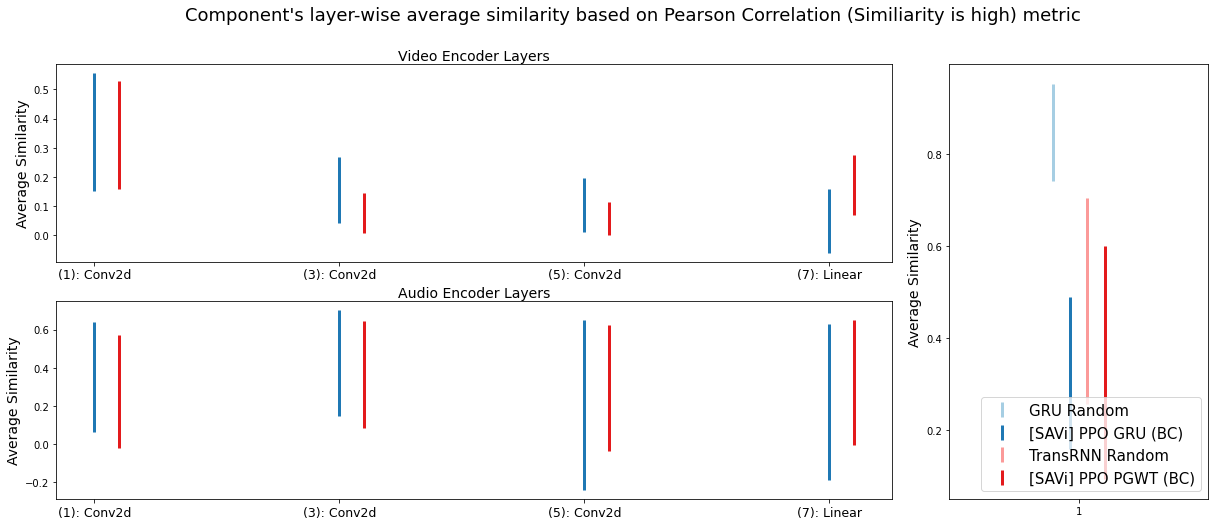

In [20]:
# Average similarities and Sparsities all in one
"""
    This expects:
        - PPO GRU Untrained (Random)
        - PPO PGWT Untrained (Random)
        - PPO GRU RL
        - PPO PGWT RL
"""
from turtle import position
from matplotlib.gridspec import GridSpec # TODO: move to the top

N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())
# VARIANTS_COLOR_PALETTE = sns.color_palette(n_colors=N_VARIANTS)
paired_color_palette = sns.color_palette("Paired")

VARIANTS_COLOR_PALETTE_DICT = {
    "ppo_gru__random": paired_color_palette[0], # Light blue
    "ppo_pgwt__random": paired_color_palette[4], # Light red
    
    # "ppo_gru__rl__SAVi": paired_color_palette[1], # Dark blue
    # "ppo_pgwt__rl__SAVi": paired_color_palette[5] # Dark red

    "ppo_gru__bc__SAVi": paired_color_palette[1], # Dark blue
    "ppo_pgwt__bc__SAVi": paired_color_palette[5] # Dark red
}
VARIANTS_BAR_SHIFTING = np.linspace(-0.1, 0.1, N_VARIANTS)[::-1]
VARIANTS_BAR_SHIFTING_1 = np.linspace(-0.1, 0.1, 3)[::-1] # For the visual and audio encoders

# VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__rl__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_gru__bc__SAVi", "ppo_pgwt__bc__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT_PALETTE = [VARIANTS_COLOR_PALETTE_DICT[k] for k in VIS_AUD_VARIANTS_TO_PLOT]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    fig = plt.figure(figsize=(16,8))

    # Visual and audo encoder layers
    gs1 = GridSpec(2, 1, left=0.0, right=0.725, wspace=0)

    ## Video encoder layers
    vis_enc_ax = fig.add_subplot(gs1[0, 0])

    visual_encoder_layernames.sort()
    visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
    x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_variant_drms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in visual_encoder_layernames_relu_skipped]

        vis_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    vis_enc_ax.set_xlabel("Video Encoder Layers", fontsize=14)
    vis_enc_ax.xaxis.set_label_position("top")
    vis_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    vis_enc_ax.set_xticks(x)
    visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    vis_enc_ax.set_xticklabels(visual_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # vis_enc_ax.legend()

    ## Audo encoder layers
    aud_enc_ax = fig.add_subplot(gs1[1, 0])

    audio_encoder_layernames.sort()
    audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

    x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in audio_encoder_layernames_relu_skipped]

        aud_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    aud_enc_ax.set_xlabel("Audio Encoder Layers", fontsize=14)
    aud_enc_ax.xaxis.set_label_position("top")
    aud_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    aud_enc_ax.set_xticks(x)
    audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    aud_enc_ax.set_xticklabels(audio_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # aud_enc_ax.legend()

    # State features plot
    gs2 = GridSpec(1,1, left=0.775, right=1.0, wspace=0.05)

    state_feat_ax = fig.add_subplot(gs2[0, 0])

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    # for t, agent_variant in enumerate(["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__random", "ppo_pgwt__rl__SAVi"]):
    for t, agent_variant in enumerate(["ppo_gru__random", "ppo_gru__bc__SAVi", "ppo_pgwt__random", "ppo_pgwt__bc__SAVi"]):
        agent_varaint_rdms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        y = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["mean"]
        yerr = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["std"]

        state_feat_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    state_feat_ax.set_ylabel("Average Similarity", fontsize=14)
    # state_feat_ax.set_ylim(-0.1, 1)
    state_feat_ax.set_xticks([1])
    state_feat_ax.set_xlim(0.5, 1.5)
    state_feat_ax.legend(fontsize=15, loc="lower right")

    fig.suptitle(f"Component's layer-wise average similarity based on {dissim_metric_data['pretty_name']} metric", fontsize=18)
    # fig.tight_layout()
    fig.show()

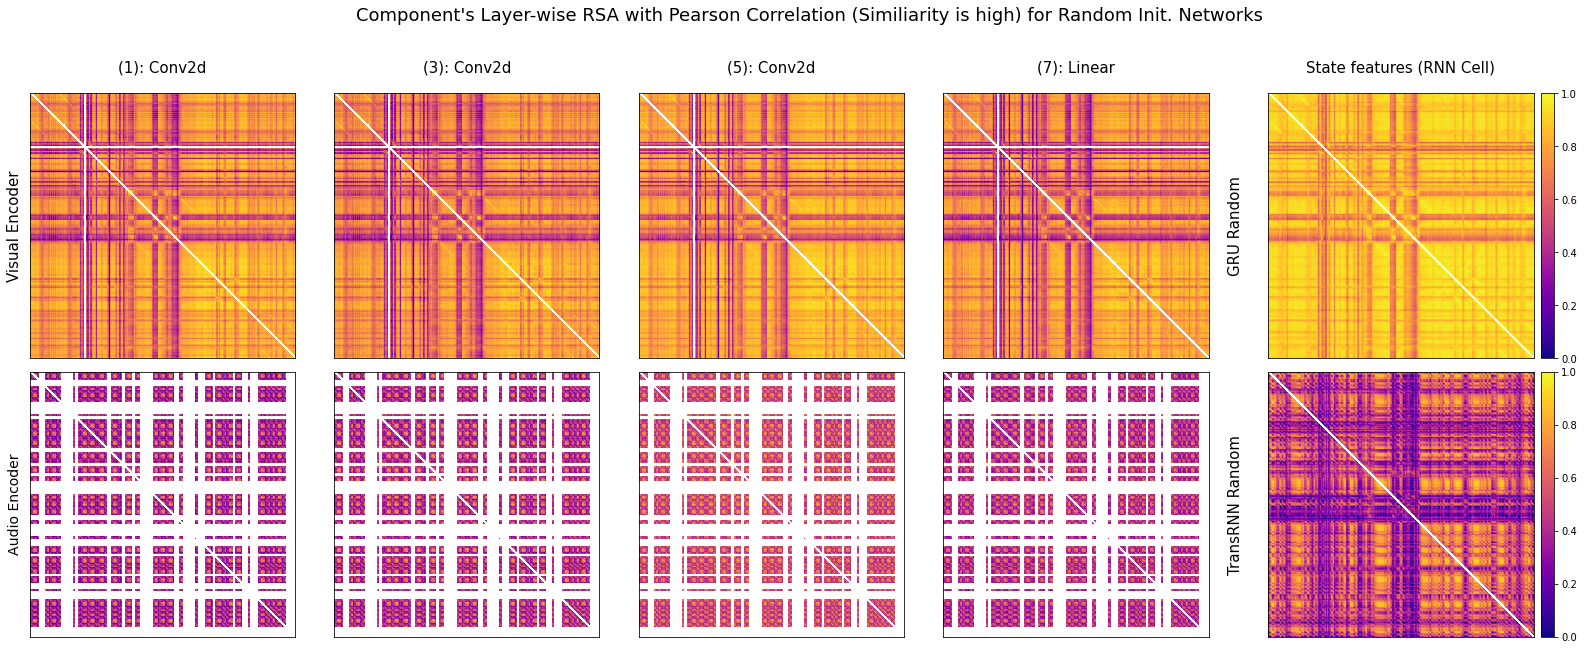

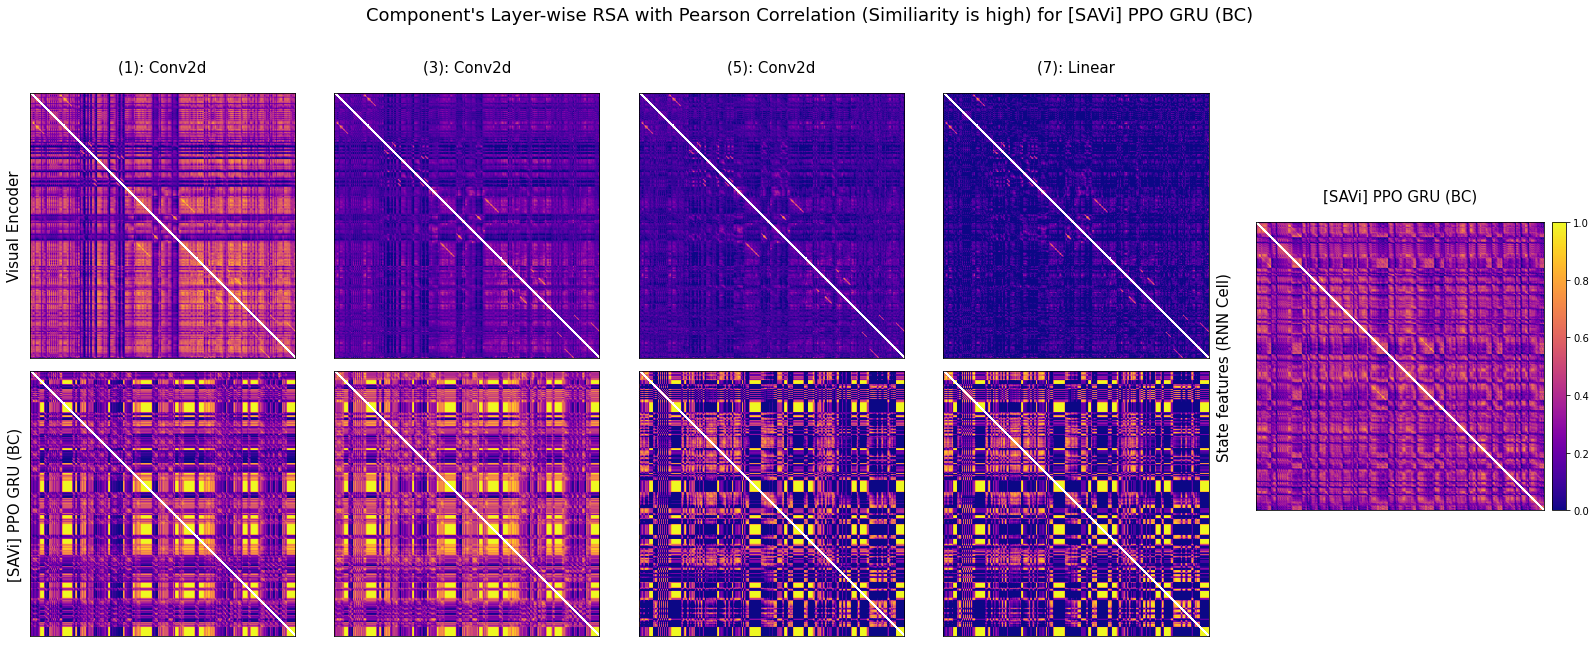

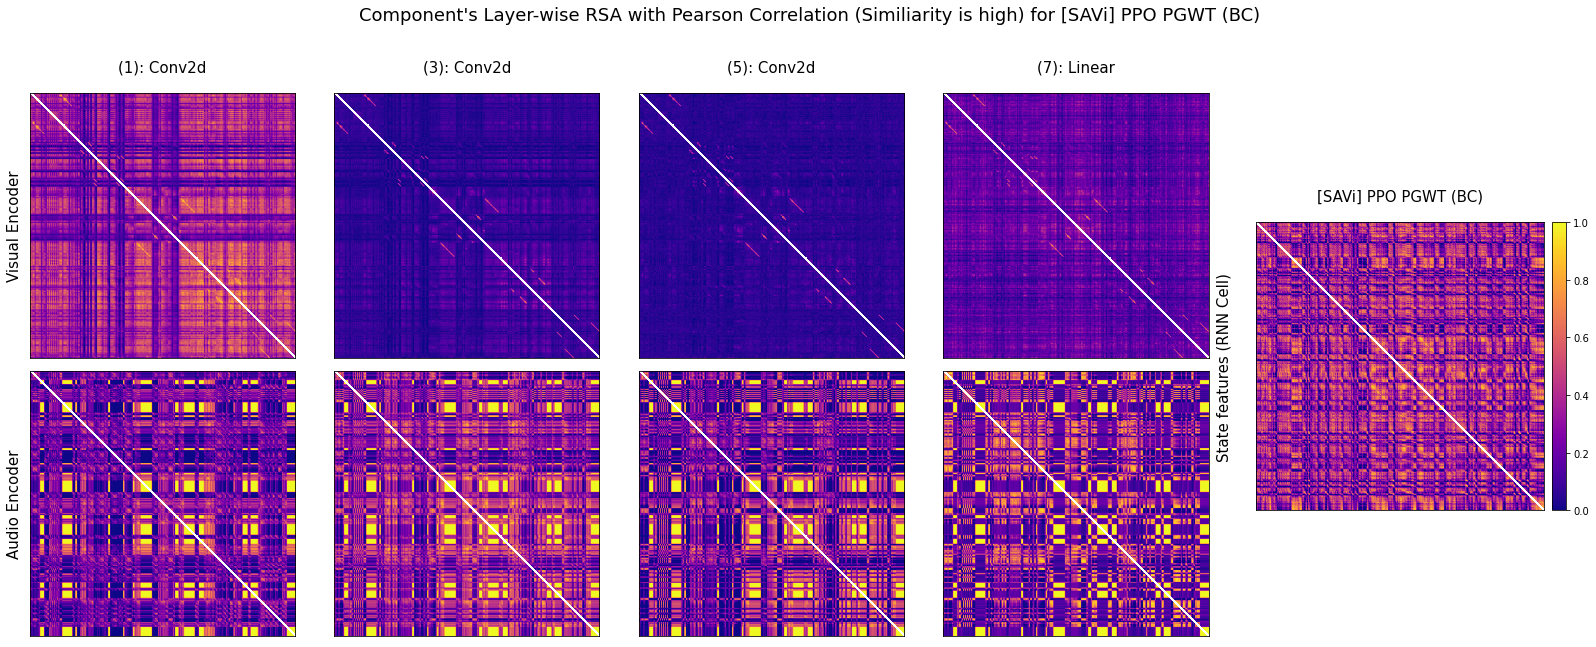

In [21]:
# All in one Plotn Style 3 Group by variant

## General

VARIANTS_TO_PLOT = [
    # BC variants
    "ppo_gru__bc__SAVi",
    "ppo_pgwt__bc__SAVi",

    # Random
    "ppo_gru__random",
    "ppo_pgwt__random",

    # # RL variants
    # "ppo_gru__rl__SAVi",
    # "ppo_pgwt__rl__SAVi",

]
VARIANTS_RMDS_TO_PLOT = {k: VARIANTS_RDMS[k] for k in VARIANTS_TO_PLOT}

N_VARIANTS = len(VARIANTS_TO_PLOT)
## Visual encoder
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

## Audio encoder
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]
audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    
    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(2, 1, left=0.78, right=0.98, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(2)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    # VMIN, VMAX = None, None
    VMIN, VMAX = 0, 1
    
    for variant_idx, agent_variant in enumerate(["ppo_gru__random", "ppo_pgwt__random"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=14)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_ylabel(f"{agent_variant_pretty}\n", fontsize=15)
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
        if variant_idx == 0:
            variant0_right_axes[variant_idx][-1].set_xlabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
            variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")

    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for Random Init. Networks", fontsize=18, y=1)
    # fig.tight_layout()
    fig.show()

    ## PPO GRU BC (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_gru__bc__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                # variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
    
    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for {agent_variant_pretty}", fontsize=18, y=1)
    fig.show()
    ## PPO PGWT BC (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_pgwt__bc__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
    
    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for {agent_variant_pretty}", fontsize=18, y=1)
    fig.show()

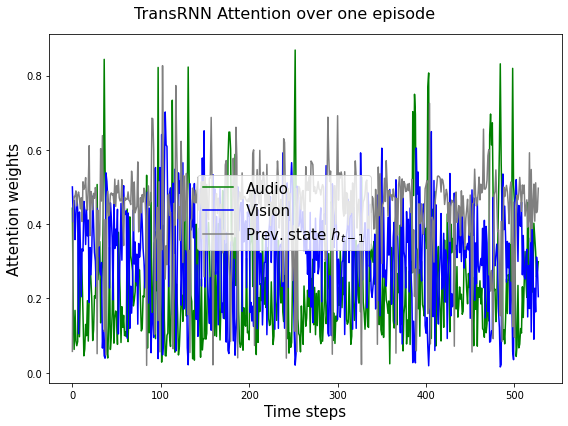

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8,6))
ep_length = AGENT_FEATURES["ppo_pgwt__bc__SAVi"]["state_encoder.ca.mha"][1].shape[0]
x = np.arange(ep_length)

MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$" }
MOD_AXIS_TO_COLOR = { 0: "green", 1: "blue", 2: "grey" }

for mod_axis in range(3):
    ax.plot(x, AGENT_FEATURES["ppo_pgwt__bc__SAVi"]["state_encoder.ca.mha"][1].mean(1)[:, mod_axis],
            label=MOD_AXIS_TO_NAME[mod_axis],
            color=MOD_AXIS_TO_COLOR[mod_axis])

ax.set_ylabel("Attention weights", fontsize=15)
ax.set_xlabel("Time steps", fontsize=15)
fig.legend(fontsize=15, loc="center")
fig.suptitle("TransRNN Attention over one episode", fontsize=16)
fig.tight_layout()
fig.show()


# Analyzing the GRU and TransRNN latents through plots, grouped by scene / category

In [ ]:
# More detailed breakdown of the trajectories per categories then scenes
SCENES_OF_INTEREST = []
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

# UMAP clustering of raw RGB obs following scene and categories

In [ ]:
chair_allscenes_alltrajs_obs_dict_list, _, target_scene_idx_list, target_category_idx_list = \
    get_traj_data_by_category(cats_scenes_trajs_dict, "chair", tensorize=False)
# The following three should all be equal: one target for scene / category for each step
len(chair_allscenes_alltrajs_obs_dict_list), len(target_scene_idx_list), len(target_category_idx_list)

In [ ]:
chair_allscenes_alltrajs_obs_rgb_list = np.array(
    [chair_allscenes_alltrajs_obs_dict_list[t]["rgb"] for t in range(len(chair_allscenes_alltrajs_obs_dict_list))])
chair_allscenes_alltrajs_obs_rgb_list.shape # [TT, H, W, C]

In [ ]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(chair_allscenes_alltrajs_obs_rgb_list.reshape(-1, 128 * 128 * 3))

In [ ]:
# Plot clusters by scene
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, c=target_scene_idx_list, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(M+1)-0.5)
cbar.set_ticks(np.arange(M))
cbar.set_ticklabels(TARGET_SCENE_LIST)
fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on scenes", fontsize=18)
fig.show()

In [ ]:
D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list, \
D7N2EKCX4Sj_allcats_alltrajs_done_list, \
D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list, \
D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list = \
        get_traj_data_by_scene(scenes_cats_trajs_dict, "D7N2EKCX4Sj", tensorize=False)
# The following three should all be equal: one target for scene / category for each step
len(D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list)

In [ ]:
D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list = np.array(
    [D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list[t]["rgb"] for t in range(len(D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list))])
D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list.shape # [TT, H, W, C]

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list.reshape(-1, 128 * 128 * 3))

In [ ]:
# Plot clusters by categories, after filtering based on `scene`
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, c=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(C+1)-0.5)
cbar.set_ticks(np.arange(C))
cbar.set_ticklabels(TARGET_CATEGORY_LIST)
fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on categories", fontsize=18)
fig.show()

# UMAP Clustering of ANN features based on scenes and categories

## 1. Scene first

In [ ]:
# T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].shape[0]
# # T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["visual_encoder.cnn.7"].shape[0]
# # T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["audio_encoder.cnn.7"].shape[0]
# fig, axes = plt.subplots(T, 1, figsize=(T * 4, 48))

# for t in range(T):
#     rnn_features = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0][t].view(8, 64)
#     axes[t].imshow(rnn_features, vmin=-1.0, vmax=1.0)
#     axes[t].set_title(f"Timestep {t}")

# fig.suptitle(f"")
# fig.show()

In [ ]:
AGENT_FEATURES.keys() # ['ppo_gru__random', 'ppo_pgwt__random', 'ppo_gru__bc__SAVi', 'ppo_pgwt__bc__SAVi']
AGENT_FEATURES["ppo_gru__bc__SAVi"].keys() # ['visual_encoder.cnn.{0,1,2,3,4,5,6,7}', 'audio_encoder.cnn.{0,1,2,3,4,5,6,7}', 'action_distribution.linear', 'critic.fc', 'state_encoder']
# AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][1] # Tuple of len 2, [0] is the [T, feat_size] vector, and [1] is [T, 1, 512] probably the current state
AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].shape # Tuple of len 2, [0] is the [T, feat_size] vector, and [1] is [T, 1, 512] probably the current state

In [ ]:
AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].min(), AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].max()

In [23]:
rnn_features = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0]; rnn_features.shape # TT x 512

torch.Size([528, 512])

In [ ]:
import umap

for n_neighbors in [8, 16, 32, 64]:
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    # embedding = reducer.fit_transform(rnn_features.numpy(), y=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list) # This is cheating though
    embedding = reducer.fit_transform(rnn_features.numpy())

    # Plot clusters by categories, after filtering based on `scene`
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*embedding.T, c=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(C+1)-0.5)
    cbar.set_ticks(np.arange(C))
    cbar.set_ticklabels(TARGET_CATEGORY_LIST)
    fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on categories | UMAP Nghbrs: {n_neighbors}", fontsize=18)
    fig.show()

## 2. Category first

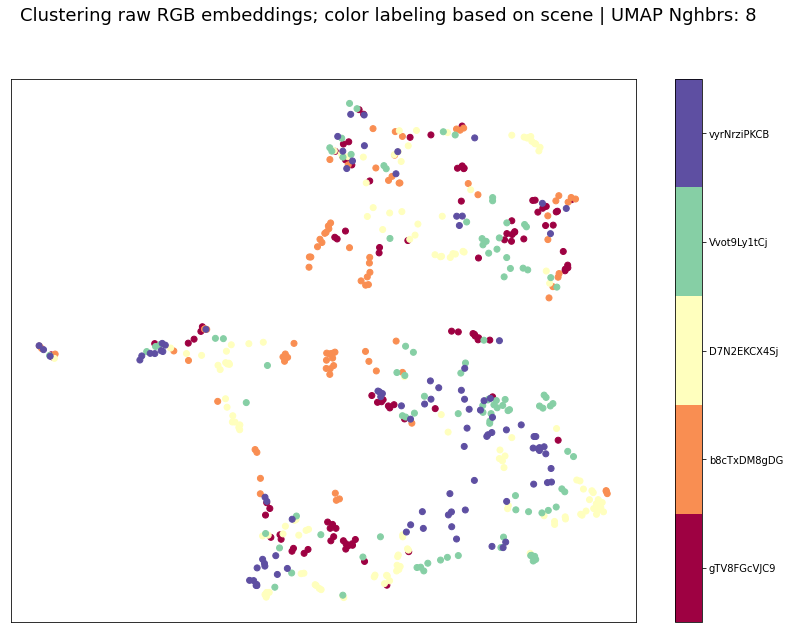

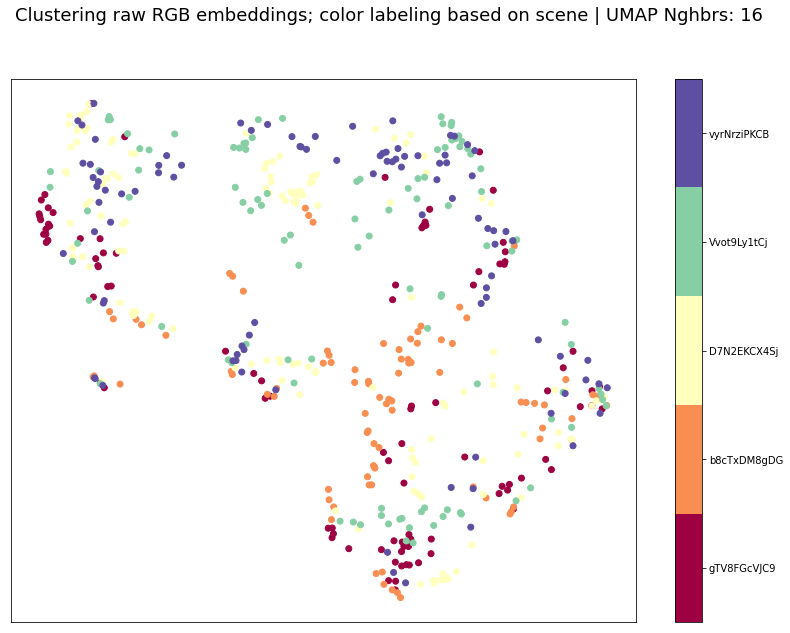

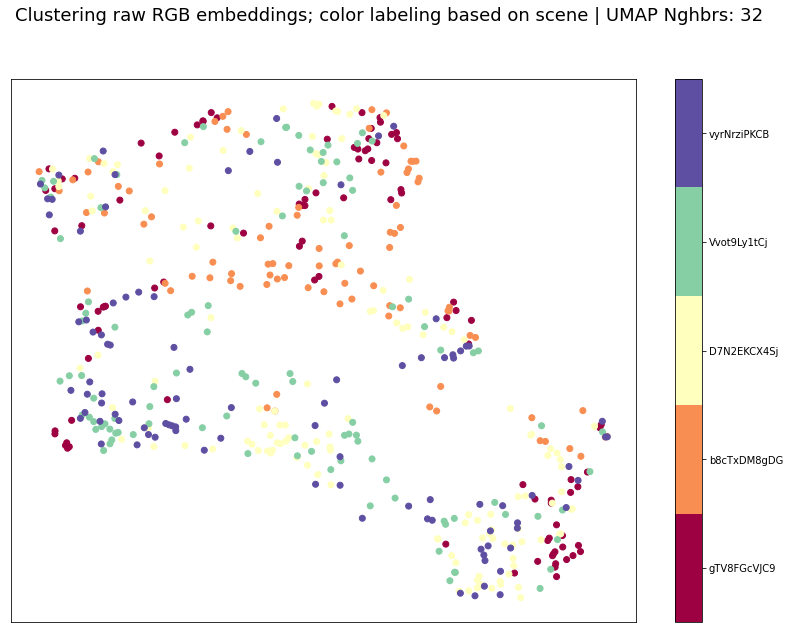

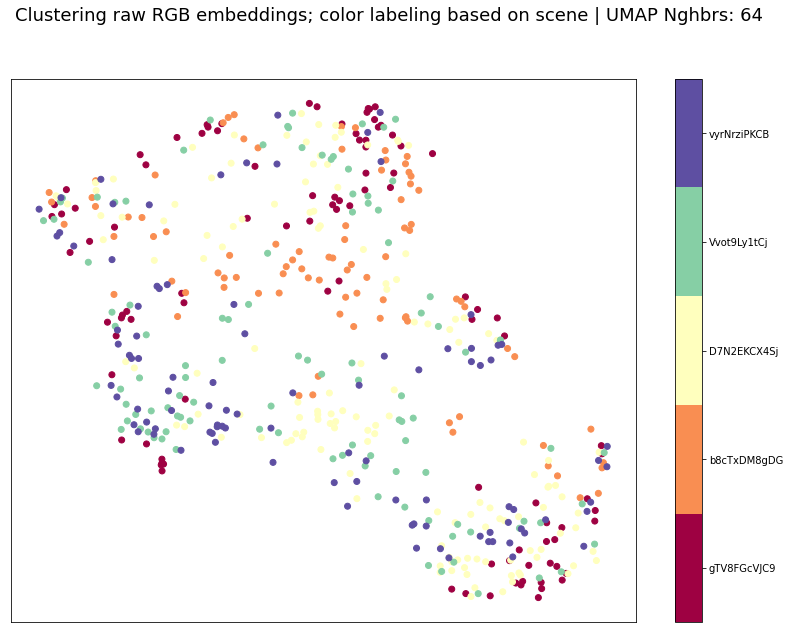

In [27]:
import umap

for n_neighbors in [8, 16, 32, 64]:
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    # embedding = reducer.fit_transform(rnn_features.numpy(), y=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list) # This is cheating though
    embedding = reducer.fit_transform(rnn_features.numpy())

    # Plot clusters by categories, after filtering based on `scene`
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*embedding.T, c=chair_allscenes_all_traj__target_scene_idx_list, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(M+1)-0.5)
    cbar.set_ticks(np.arange(M))
    cbar.set_ticklabels(TARGET_SCENE_LIST)
    fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on scene | UMAP Nghbrs: {n_neighbors}", fontsize=18)
    fig.show()